# Import Libraries


Importing necessary libraries and modules required to build the classification model.

In [1]:
import numpy as np
import pickle
import cv2
import os
from zipfile import ZipFile
import gdown
import tensorflow
import requests
import matplotlib.pyplot as plt
from os import listdir
from os import path
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
# from tensorflow import BatchNormalization
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
from scipy.sparse import extract

# Download a file based on its file ID.
if path.exists('PlantVillage') == False:
  if path.exists('PlantVillage.zip') == False:
    URL = "https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn"
    output= "PlantVillage.zip"
    gdown.download(URL,output,quiet=False)
    file_name = "PlantVillage.zip"
    with ZipFile('PlantVillage.zip', 'r') as zf:
      zf.extractall()
  else:
    with ZipFile('PlantVillage.zip', 'r') as zf:
      zf.extractall()


# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [3]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

*NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak `N_IMAGES` to include entire dataset.*

In [5]:
image_list, label_list = [], []

try:
    print(" Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f" Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)e

    print(" Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing background ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot 

Examine the labels/classes in the training dataset.

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [7]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [8]:
print(" Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


# Build Model


Defining the hyperparameters of the plant disease classification model.

In [9]:
EPOCHS = 20 #12 workable
STEPS = 100 
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [10]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

# Train Model


We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

In [1]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print(" Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

IndentationError: unexpected indent (2129980577.py, line 2)

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

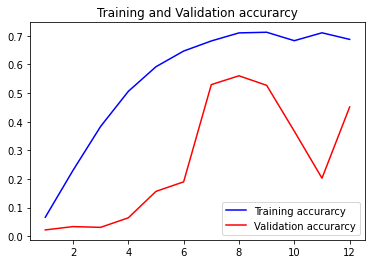

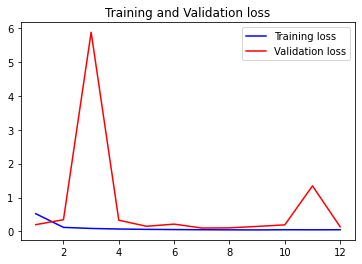

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [22]:
print(" Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
25/25 [==============================] - 16s 660ms/step - loss: 0.1371 - accuracy: 0.4513
Test Accuracy: 45.12820541858673


# Save Model

In [87]:
model.save('C:\\Users\\zawat\\OneDrive\\Desktop\\python project\\Model')

INFO:tensorflow:Assets written to: C:\Users\zawat\OneDrive\Desktop\python project huz\Model.pkl\assets


INFO:tensorflow:Assets written to: C:\Users\zawat\OneDrive\Desktop\python project huz\Model.pkl\assets


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [83]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = (np.array(image_array, dtype=np.float16) / 225.0)
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = np.argmax(model.predict(np_image),axis=-1)
    print((image_labels.classes_[result]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

1/1 [==============================] - 0s 87ms/step
['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot']


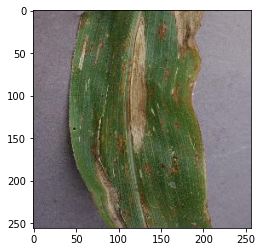

In [85]:
predict_disease('C:\\Users\\zawat\\onedrive\\desktop\\python project\\PlantVillage\\val\\Corn_(maize)___Northern_Leaf_Blight\\00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.jpg')

# Reuse Model

Importing necessary libraries and modules required to build the classification model.

In [89]:
import numpy as np
import pickle
import cv2
import keras
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
# from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Loading the trained model to reuse the model without always training

In [90]:
model = keras.models.load_model('C:\\Users\\zawat\\OneDrive\\Desktop\\python project\\Model.pkl')

converting image to array and defining a function to predict the disease

In [94]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        # print(image)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = (np.array(image_array, dtype=np.float16) / 225.0)
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = np.argmax(model.predict(np_image),axis=-1)
    # result = model.predict_classes(np_image)
    print((image_labels.classes_[result]))

Predict disease of any plant image.

1/1 [==============================] - 0s 58ms/step
['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot']


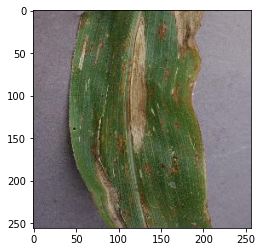

In [95]:
predict_disease('C:\\Users\\zawat\\onedrive\\desktop\\python project\\PlantVillage\\val\\Corn_(maize)___Northern_Leaf_Blight\\00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.jpg')